In [127]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

##Creating an empty list
file=[]
#Reading json file 
for line in open('Beauty_5.json', 'r'):
    file.append(json.loads(line))
##Converting json to csv format
df=pd.DataFrame(file)
df.shape


(198502, 9)

In [128]:
df.columns
df.info()
df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      198502 non-null  object 
 1   asin            198502 non-null  object 
 2   reviewerName    197116 non-null  object 
 3   helpful         198502 non-null  object 
 4   reviewText      198502 non-null  object 
 5   overall         198502 non-null  float64
 6   summary         198502 non-null  object 
 7   unixReviewTime  198502 non-null  int64  
 8   reviewTime      198502 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 13.6+ MB


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"


In [129]:
#Rating below 2.5 is considered as Negative and above 2.5 is positive
Reaction=[]
for i in range(0,df.shape[0]):
  if df['overall'][i] > 3:
    Reaction.append("Positive")
  else: 
    Reaction.append("Negative")

df["Result"]=Reaction



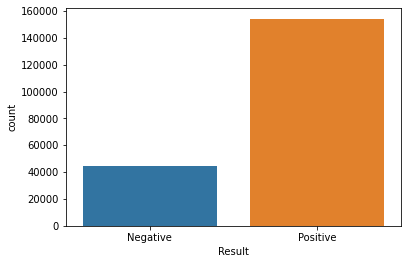

In [130]:
###Checking Biasness
#There are more Positive reveiws
sns.countplot(x ='Result', data = df) 


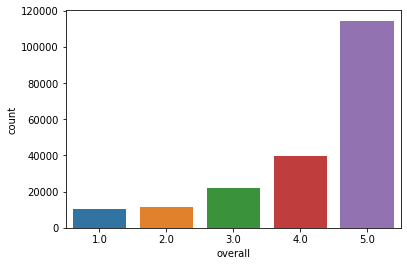

In [131]:
sns.countplot(x =df['overall'].astype(object), data = df) 

In [132]:
Text=pd.concat([df['reviewText'], df['Result']], axis=1)

In [133]:
#Text cleaning
#Since there are no quotes
import re  #For stemming
import nltk  #For stop words (The, and, hi)
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, len(Text)):
  review = re.sub('[^a-zA-Z]', ' ', Text['reviewText'][i]) #Removing Punctualtion
  review = review.lower()  #Changing it to lower case
  review = review.split()  #Splitting word
  ps = PorterStemmer()  #Stemming (Loving/Loved->Love)
  all_stopwords = stopwords.words('english') #Removing (Then, they, I, has)
  all_stopwords.remove('not')
  all_stopwords.remove('very')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)
print(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [134]:
###Making sparse MATRIX
from sklearn.feature_extraction.text import CountVectorizer
CV=CountVectorizer(max_features = 1100)#Taking most frequent words, removing those who appeared least
x=CV.fit_transform(corpus).toarray()
y=Text['Result']

In [157]:
x.shape

(198502, 1100)

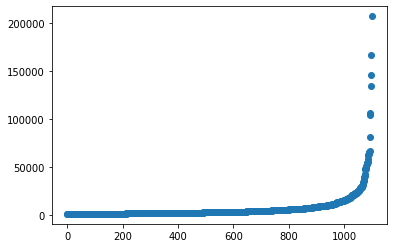

In [136]:
##Visualizing
total=np.sum(x, 0)
total.sort()
total.shape
i=list(range(0,total.shape[0]))
plt.scatter(i,total)


In [137]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [155]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='sag', max_iter=400)
classifier.fit(x_train, y_train)
#Predicting the Test set results
y_pred = classifier.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [156]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 4559  4310]
 [ 1592 29240]]


0.8513387572101458

In [145]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 12, criterion = 'entropy')
RF.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=12,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [146]:
y_pred1=RF.predict(x_test)
print(confusion_matrix(y_test, y_pred1))
accuracy_score(y_test, y_pred1)


[[ 3783  5086]
 [ 1880 28952]]


0.824538424724818